# Ensemble Modeling Demonstration

In the previous notebook, we constructed a number of different models with the aim of predicting the average US domestic price for a non-organic avocado based on three years of historical data. In this notebook we will see how multiple models may be combined to generate predictions that outperform any one of the models on its own. 

A number of ensemble modeling methods are available to choose from, depending on the type of problem being solved. For the sake of discussion, here is a list of methods (non-exaustive, despite its lenght):

### Averaging Methods

<ul>
<li>Voting Ensembles</li>
<li>Weighted Voting</li>
<li>Averaging (and Geometric averaging)</li>
<li>Weighted Averaging</li>
<li>Ranked Averaging
</ul>

### Stacked Generalization Methods

Two categories:
<ul>
<li>Stacked Generalization</li>
<li>Blended models</li>
</ul>
depending on how you split up your data between test and train

Some specific stacking architectures:
<ul>
<li>Feature weighted linear stacking</li>
<li>Quadratic Linear Stacking</li>
<li>Stacking regressors with Classifiers</li>
<li>Stacking classifiers with regressors</li>
<li>Unsupervised learning model stacking</li>
</ul>

... and so on. <b>Feature weighted linear stacking</b> would be the most adaptive formulation of ensembling, and very appropriate for the JunEngine use case. In these scenarios, stacks engineered meta-features are combined together with model predictions. The hope is that the stacking model learns which base model is the best predictor for samples with a certain feature value. 

Let's attempt to contruct an ensemble wherein we take a weighted average of outputs of the L1 learners. 

In [1]:
## Library imports
import math
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# import lightgbm as lgb


import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from fbprophet import Prophet

import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [2]:
import sklearn
version = sklearn.__version__
print(f"This notebook was created using scikit-learn version 0.19.0\nYour version: {version}")

This notebook was created using scikit-learn version 0.19.0
Your version: 0.19.0


## Feature engineering
The pricing data set has granularity of one week. Here we transform the date column into year, month, and week of the year columns. We also include the number of weeks until Cinco de Mayo, and important holiday in some Latin-American communities.

In [3]:
## Data preparation
raw_data = pd.read_csv("avocado.csv")
data = raw_data.loc[ ( raw_data['region']=='TotalUS' ) & ( raw_data['type']=='conventional' ) ].copy()[['Date', 'year', 'AveragePrice']]
data = data.assign( Date=pd.to_datetime(data.Date) )
data = data.assign( month=[x.month for x in data.Date])
data = data.assign( week=[x.isocalendar()[1] for x in data.Date])
# Weeks until 'Cinco dey Mayo'
data = data.assign( weeks_before_cdm=[ dt.datetime(r['year'], 5, 5).isocalendar()[1] - r['week'] for i, r in data.iterrows() ] )
data = data.sort_values(['year', 'week' ], ascending=[True, True])
data = data.reset_index(drop=True)

It is sometimes said that for a time series such as ours, tomorrow's price will be today's price, to first order. Indeed, in the previous notebook, we saw that the current price is strongly correlated with the price over the prior 10 weeks. We will therefore included lagged price features for that time interval. Consequently, we also will chop off the first ten weeks of data from our datset to be used for model fitting and cross-validation. 

In [4]:
n_lags = 1
lagged_price = [ data['AveragePrice'].iloc[n_lags-n:len(data)-n].values for n in np.arange(1,n_lags+1) ] 
lags = [ 'price_lagged_' + str(n) for n in np.arange(1,n_lags+1) ]
lagged_price_df = pd.DataFrame( { l:p for l, p in zip(lags,lagged_price) } )  
lagged_price_df = lagged_price_df.reset_index(drop=True)
data_chopped = data.iloc[n_lags:].copy()
data_chopped = data_chopped.reset_index(drop=True)
merged_data = data_chopped.merge( lagged_price_df, left_index=True, right_index=True )
# merged_data = merged_data.drop(columns=['Date', 'Date'])

In [5]:
merged_data.head(10+n_lags)

,Date,year,AveragePrice,month,week,weeks_before_cdm,price_lagged_1
0,2015-01-11,2015,1.01,1,2,17,0.95
1,2015-01-18,2015,1.03,1,3,16,1.01
2,2015-01-25,2015,1.04,1,4,15,1.03
3,2015-02-01,2015,0.89,2,5,14,1.04
4,2015-02-08,2015,0.95,2,6,13,0.89
5,2015-02-15,2015,1.03,2,7,12,0.95
6,2015-02-22,2015,1.02,2,8,11,1.03
7,2015-03-01,2015,0.97,3,9,10,1.02
8,2015-03-08,2015,1.02,3,10,9,0.97
9,2015-03-15,2015,1.04,3,11,8,1.02


### Subsamples for L1-learner cross-valiation and aggregator training


We will split our data in half and use the first half for training and cross-validation of the L1-learners. The second half (the out-of-fold sample) will be used to train and cross-validate the aggregator, using the predictions of the L1 learners as input features. 

In [6]:
i_oof_start = len(merged_data)//2
target = "AveragePrice"
X_features = [ c for c in merged_data.columns.values if ( target not in c and 'Date' not in c ) ]

In [7]:
X_L1 = merged_data.iloc[:i_oof_start][X_features].values
Y_L1 = merged_data.iloc[:i_oof_start]['AveragePrice'].values.ravel()

## Class and method definitions for our models
In this section we define classes and methods to simplify our lives as we go about model training and cross validation. It was necessary to write our own classes so that we can take a closer look at what is happening during the training and cross-validation stages.

In [8]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        """Class implementing a simple averaging ensemble model."""
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [9]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=3):
        """Class implementing a Stacked-average Ensemble with a meta-learner."""
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = TimeSeriesSplit(n_splits=self.n_folds)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # Do the predictions of all base models on the test data and use the averaged 
    # predictions as meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [152]:
class TSCrossValidationHandler():
    def __init__(self, model, name, n_splits=3):
        """Class for handling time-series model cross-validation explicitly.
        
        This is needed in order to view the model fit results for each of the folds
        and to extract the model predictions for use as training features for an 
        ensemble model.        
        """
        self.model = model
        self.name = name
        self.n_splits = n_splits
        self.test_X = []
        self.test_resid_Y = []
        self.test_true_Y = []
        self.test_pred_Y = []
        self.train_X = []
        self.train_true_Y = []
        self.train_resid_Y = []
        self.train_pred_Y = []
        self.mses = []
        self.mapes = []
        self.figsize = (14, 9)

    def do_cross_val(self, X, Y):
        ## Do a log transform on Y
        tscv = TimeSeriesSplit(n_splits=self.n_splits) 
        i = 1
        for i_train, i_test in tscv.split(X):
            self.model.fit(X[i_train], Y[i_train])
            self.train_resid_Y.append([y-y_true for y_true,y in zip(Y[i_train],
                                                                    self.model.predict(X[i_train]))])
            self.train_true_Y.append(Y[i_train]) 
            self.train_X.append(i_train)
            self.train_pred_Y.append([y for y in self.model.predict(X[i_train])])
            self.test_resid_Y.append([y-y_true for y,y_true in zip(self.model.predict(X[i_test]), 
                                                                   Y[i_test])])
            self.test_true_Y.append(Y[i_test])
            self.test_X.append(i_test)
            self.test_pred_Y.append([y for y in self.model.predict(X[i_test])])                    
            self.mses.append(mean_squared_error(Y[i_test], self.model.predict(X[i_test])))
            self.mapes.append(100*np.mean([(y-Y[i])/Y[i] for i,y in zip(i_test,
                                                                        self.model.predict(X[i_test]))]))
            print(f"Fold {i} complete with: {len(i_train)} training samples and {len(i_test)} test samples.")
            i += 1
    
    def fit_and_evaluate(X_train, Y_train, X_test, Y_test):
        """Do a single fit to a training dataset and evaluation on a test dataset."""
        self.model.fit(X_train, Y_train)
        y_train_pred = self.model.predict(X_train)
        y_train_errs = [y-y_true for y_true, y in zip(Y_train, y_train_pred)]
        y_test_pred = self.model.predict(X_test)
        y_test_errs = [y-y_true for y_true, y in zip(Y_test, y_test_pred)]
        mse = mean_squared_error(Y_test, y_test_pred)
        mape = 100*np.mean([(y-Y)/Y for Y,y in zip(Y_test,y_test_pred)])
        pstddev = 100*np.std([(y-Y)/Y for Y,y in zip(Y_test,y_test_pred)])
        return { "Model":self.name, 
                 "MSE":mse, 
                 "MAPE":mape, 
                 "STDDEV":pstddev, 
                 "Y_errs":y_test_errs, 
                 "Y_predicted":y_test_pred }

    def report_metrics(self):
        mse_mean = round(np.sqrt(np.mean(self.mses)),3)
        mse_std = round(np.sqrt(np.std(self.mses)),3)
        mape_mean = round(np.mean(self.mapes),3)
        mape_std = round(np.std(self.mapes),3)
        print(f"Cross-validation results for {self.name}:")
        print(f"   RMSE:   {mse_mean} \xb1 {mse_std}")
        print(f"   MAPE: ({mape_mean} +/- {mape_std})%")
        print(f"   N Splits: {self.n_splits}\n")
        
    def get_metrics(self):
        mse_mean = round(np.sqrt(np.mean(self.mses)),3)
        mse_std = round(np.sqrt(np.std(self.mses)),3)
        mape_mean = round(np.mean(self.mapes),3)
        mape_std = round(np.std(self.mapes),3)    
        return { 'mse_mean':mse_mean, 'mse_std':mse_std, 'mape_mean':mape_mean, 'mape_std':mape_std }
    
    def plot_fits(self):
        """Plot the results of cross validation.
        
        Returns:
        ax -- An axis object containing the resultant plot
        
        """
        X_all_test = np.array(self.test_X).flatten()
        Y_all_test = np.array(self.test_true_Y).flatten()
        Y_all_test_pred = np.array(self.test_pred_Y).flatten()
        Y_resid_all_test = np.array(self.test_resid_Y).flatten()
        X_all_train = np.array(self.train_X).flatten()
        Y_all_train = np.array(self.train_true_Y).flatten()
        Y_all_fit = np.array(self.train_pred_Y).flatten()
        Y_all_fit_resid = np.array(self.train_resid_Y).flatten()
            
        # Plot the real data vs. the model 
        fig = plt.figure(figsize=self.figsize)
        fig.suptitle(f"Cross-validation Results for {self.name}", fontsize=16)
        plt.subplot(311)
        plt.title("Model Predicted Price vs. Actual Price (all folds combined)")
        ax1 = plt.plot(X_all_test, Y_all_test, marker='o', color='black', label="True Y")
        ax1 = plt.plot(X_all_test, Y_all_test_pred, marker='o', color='blue', label="Predicted Y" )
        
        plt.subplot(312)
        plt.title("Model Prediction Errors")
        ax2 = plt.plot(X_all_test, Y_resid_all_test, marker='o', color='blue')
        sqrtmse = np.sqrt(np.mean(self.mses))
        ax2 = plt.plot([ X_all_test[0], X_all_test[-1]], [-sqrtmse, -sqrtmse], 'r--')
        ax2 = plt.plot([ X_all_test[0], X_all_test[-1]], [ sqrtmse,  sqrtmse], 'r--')
        
        
        plt.subplot(313)
        plt.title("Model Fit residuals (Final Training Split)")
        ax3 = plt.plot(X_all_train[-1], Y_all_fit_resid[-1], marker='o', color='green')
        
        plt.show()
        
        return fig

# Train and evaluate the Base Learners
For each of the L1 models, or base learners, we perform cross-validation and evaluate the model performance by plotting:
<ol>
<li>the predicted vs. true price
<li>the difference between the model prediction and true price
<li>the residuals from the model fit from the final cross-validation sample as well as a fit to the whole L1-training/cross-validation data set
</ol>

In [140]:
model_pipelines = []
handlers = []
figures = []
L1_cv_splits = 3

### Random Forrest

Fold 1 complete with: 21 training samples and 21 test samples.
Fold 2 complete with: 42 training samples and 21 test samples.
Fold 3 complete with: 63 training samples and 21 test samples.
Cross-validation results for Random Forrest:
   RMSE:   0.08 ± 0.054
   MAPE: (1.764 +/- 5.193)%
   N Splits: 3



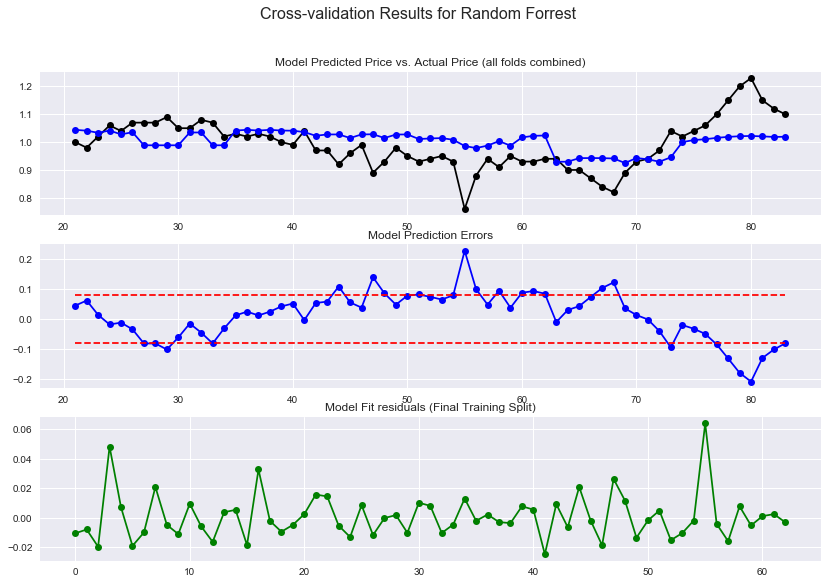

In [141]:
# Random forrest
estimator = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           n_estimators=300, n_jobs=-1, random_state=0 )
estimator_name = "Random Forrest"
pipeln = make_pipeline(StandardScaler(), estimator)
model_pipelines.append( (estimator_name, pipeln) )
handlers.append(TSCrossValidationHandler(pipeln, estimator_name, n_splits=L1_cv_splits))
handlers[-1].do_cross_val(X_L1, Y_L1)
handlers[-1].report_metrics()
figures.append(handlers[-1].plot_fits())

Notes that the predictions for the first two of the three splits (samples 0-21 and 22-42) are nearly uniform, and the final split sample doesn't see a lot of variation in the prediction either. This is an indication that we simply don't have enough data to train a random forest regressor. However, we'll keep this model in our list as a point of comparison for other models.

### XGBoost

Fold 1 complete with: 21 training samples and 21 test samples.
Fold 2 complete with: 42 training samples and 21 test samples.
Fold 3 complete with: 63 training samples and 21 test samples.
Cross-validation results for XGBoost:
   RMSE:   0.099 ± 0.068
   MAPE: (0.822 +/- 6.108)%
   N Splits: 3



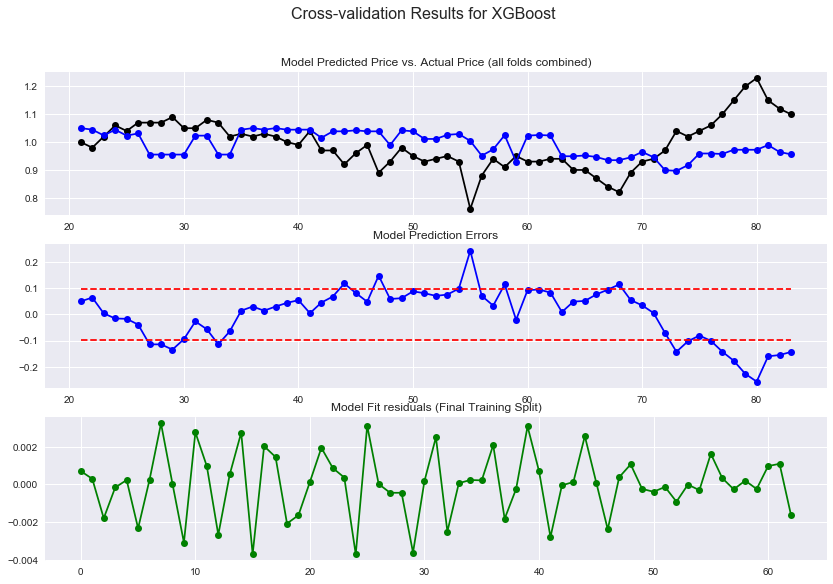

In [142]:
# XGBoost
estimator = XGBRegressor(n_estimators=1000, learning_rate=0.5, early_stopping_rounds=5)
pipeln = make_pipeline(StandardScaler(), estimator)
estimator_name = "XGBoost"
model_pipelines.append( (estimator_name, pipeln) )
handlers.append(TSCrossValidationHandler(pipeln, estimator_name, n_splits=L1_cv_splits))
handlers[-1].do_cross_val(X_L1, Y_L1)
handlers[-1].report_metrics()
figures.append(handlers[-1].plot_fits())

In [143]:
### Lasso Regression

Fold 1 complete with: 21 training samples and 21 test samples.
Fold 2 complete with: 42 training samples and 21 test samples.
Fold 3 complete with: 63 training samples and 21 test samples.
Cross-validation results for Lasso Regression:
   RMSE:   0.08 ± 0.059
   MAPE: (1.355 +/- 5.727)%
   N Splits: 3



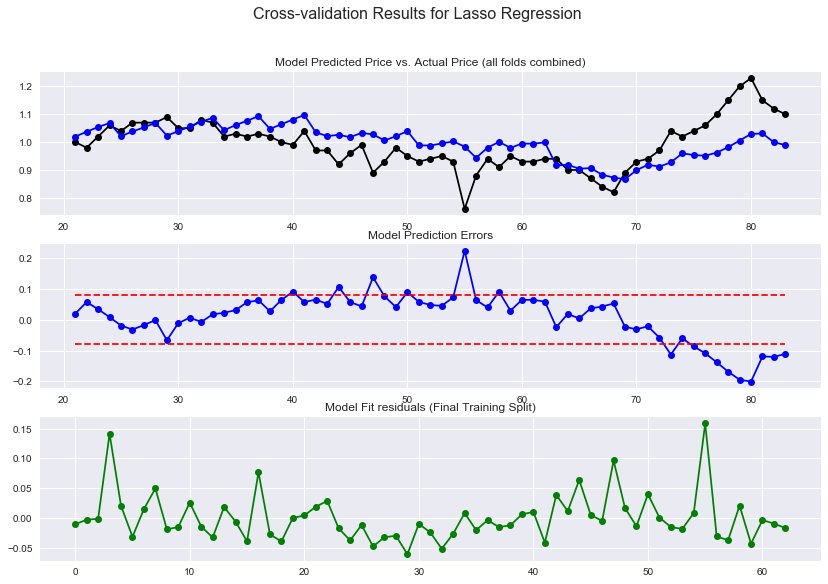

In [144]:
# Lasso regression
estimator = Lasso(alpha =0.0005, random_state=1)
pipeln = make_pipeline(StandardScaler(), estimator)
estimator_name = "Lasso Regression"
model_pipelines.append( (estimator_name, pipeln) )
handlers.append(TSCrossValidationHandler(pipeln, estimator_name, n_splits=L1_cv_splits))
handlers[-1].do_cross_val(X_L1, Y_L1)
handlers[-1].report_metrics()
figures.append(handlers[-1].plot_fits())

### Elastic Net

Fold 1 complete with: 21 training samples and 21 test samples.
Fold 2 complete with: 42 training samples and 21 test samples.
Fold 3 complete with: 63 training samples and 21 test samples.
Cross-validation results for Elastic Net:
   RMSE:   0.079 ± 0.058
   MAPE: (1.725 +/- 5.615)%
   N Splits: 3



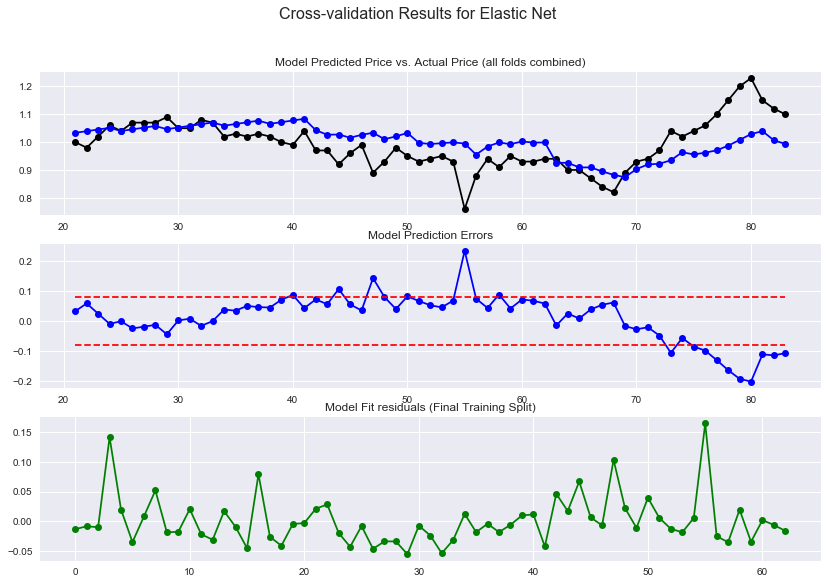

In [145]:
# Elastic Net Regression :again made robust to outliers
estimator = ElasticNet(alpha=0.002, l1_ratio=.9, random_state=3)
estimator_name = "Elastic Net" 
pipeln = make_pipeline(StandardScaler(), estimator)
model_pipelines.append( (estimator_name, pipeln) )
handlers.append(TSCrossValidationHandler(pipeln, estimator_name, n_splits=L1_cv_splits))
handlers[-1].do_cross_val(X_L1, Y_L1)
handlers[-1].report_metrics()
figures.append(handlers[-1].plot_fits())

### Kernel Ridge Regression

Fold 1 complete with: 21 training samples and 21 test samples.
Fold 2 complete with: 42 training samples and 21 test samples.
Fold 3 complete with: 63 training samples and 21 test samples.
Cross-validation results for KRR:
   RMSE:   0.188 ± 0.177
   MAPE: (-1.294 +/- 11.676)%
   N Splits: 3



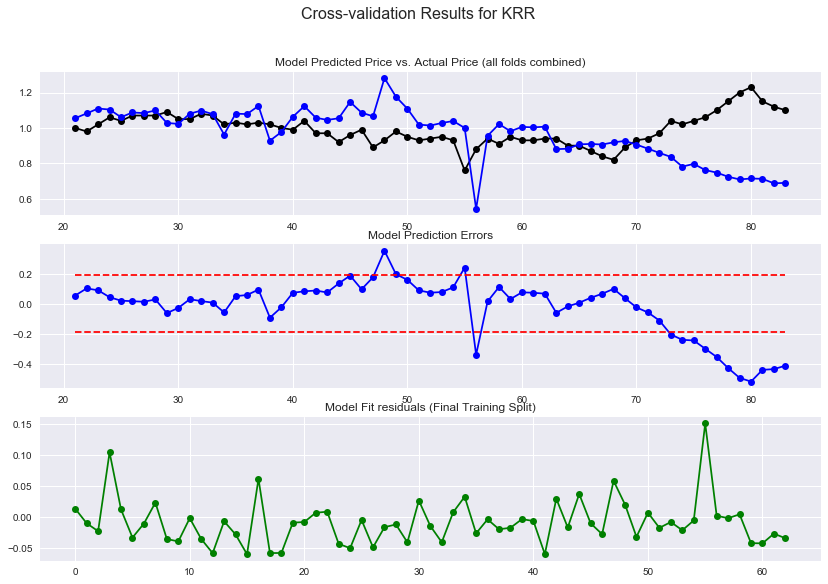

In [146]:
# Kernel Ridge Regression :
# estimator = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
estimator = KernelRidge(alpha=0.6, kernel='polynomial', degree=3)
estimator_name = "KRR"
pipeln = make_pipeline(StandardScaler(), estimator)
model_pipelines.append( (estimator_name, pipeln) )
handlers.append(TSCrossValidationHandler(pipeln, estimator_name, n_splits=L1_cv_splits))
handlers[-1].do_cross_val(X_L1, Y_L1)
handlers[-1].report_metrics()
fig_rf = handlers[-1].plot_fits()

# Base Model Selection

Let's begin by looking at how well the models performed as measured by the RMSE an MAPE

In [147]:
results_summary = { h.name : h.get_metrics() for h in handlers }
data = { m_name : [ m['mse_mean'], m['mse_std'], m['mape_mean'], m['mape_std']] for m_name, m in results_summary.items() }
results_summary_df = pd.DataFrame().from_dict(data, orient='index', columns=['MSE', 'MSE sdev', 'MAPE', 'Sdev [%]'])

In [148]:
results_summary_df

,MSE,MSE sdev,MAPE,Sdev [%]
Random Forrest,0.080,0.054,1.764,5.193
XGBoost,0.099,0.068,0.822,6.108
Lasso Regression,0.080,0.059,1.355,5.727
Elastic Net,0.079,0.058,1.725,5.615
KRR,0.188,0.177,-1.294,11.676


So it looks like Kernel Ridge Regression finishes in last place, and Elastic Net does the best in terms MSE, and XGBoost is our winner in terms of bias.  

Now let's look at correlations of the errs between models.

In [149]:
## Let's look at the fit errors and how they correlate between models
m_names = [ h.name for h in handlers ]
test_Y_err = [ np.array(h.test_resid_Y).flatten() for h in handlers ]
errs_df = pd.DataFrame.from_dict( { n : errs for n, errs in zip(m_names, test_Y_err) }, orient='columns')

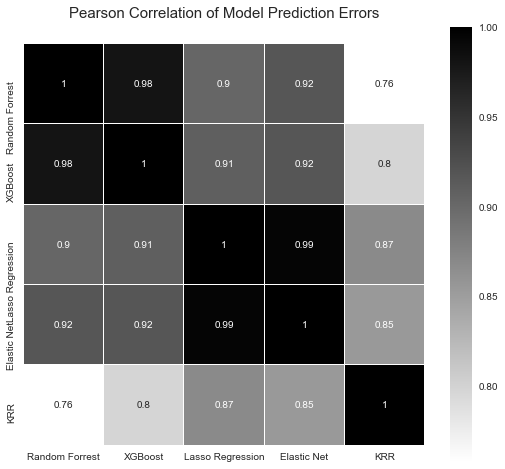

In [150]:
colormap = plt.cm.binary
plt.figure(figsize=(9,8))
plt.title('Pearson Correlation of Model Prediction Errors', y=1.05, size=15)
ax = sns.heatmap(errs_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

From the Model prediction error correlation plot we note the following:
<ul>
<li>The Elastic Net and Lasso Regression models are almost perfectly correlated, and it's not immediately clear why. 
<li>The Kernel Ridge Regression, while being the least powerful model as measured by it's MSE, is also the least correlated with the other models, which is an argument for keeping it in the stack. 
<li>In fact, with the exception of KRR, all of our models seem to be highly correlated. However, looking at the errs of each model, we note that most of them look they the simply did not have enough training data.  
</ul>
Since Elastic Net and Lasso Regression are identical, we should consider eliminating one of them going forward. Later we'll see if that makes a difference in the aggregated performance 

## Stacked Model with Meta Learner

Now we go about constructing a stacked ensemble model consisting of a meta-learner which is given as input features the predictions of the L1-learners. We can also include any additional features we wish to engineer that might help the meta-learner decide which L1-learne does the best under a given set of circumstances. 

As for the choice of the Regressor for the aggregator, we note that non-linear algorithms find useful interactions between the original features and the meta-model features, but in our case we probably do not have a large enough data set to see this come into effect. 

### Dataset preparation & meta-feature engineering

Let's prepare our dataset for the fitting and cross-validation of the aggregator. Given that we have seen we are limited by a small set of training data, it is worth rethinking our original plan for splitting the data up. Our original plan would have involved using about 3/4 of the L1-training/cross-validation data set (the 3/4 for which we have model predictions direived for training, and the remaining half for testing and evaluation. However, given how thirsty our model are for training data we will take the following, slightly modified approach: in order to increase the size of the training data set, we will reserve just the last third for our test set. To get the L1 predictions as features for the test set, we will use the predictions from our cross-validation exercise for original first half and use predictions from the models trained on the entire first have for the remainder of the first 2/3 (this would be easier to explain if I had time to make a figure).

In this section we will:
<ol>
<li>Fit our L1 models to the entire original training data set and use them to make predictions for second half of the data set, the first third of which will be used in trainig and cross-validation of our aggregator along with the predictions from L1 cross-validation, and the remainder be used as X-features for the test data sample. 
<li>Add the L1 model predictions as X-features
<li>Split the data set into training/cross-validation and test samples for the aggregator. 
</ol>

In [151]:
## For now, 'test' and 'train' are only for generating the missing y-predictions needed as features
## Later, the test set will be the last third of the data set
X_train = merged_data.iloc[:i_oof_start][X_features].values
Y_train = merged_data.iloc[:i_oof_start]['AveragePrice'].values.ravel()
X_test = merged_data.iloc[i_oof_start:][X_features].values
Y_test = merged_data.iloc[i_oof_start:]['AveragePrice'].values.ravel()

In [ ]:
final_L1_fit_results = []
for h in handlers:
    final_L1_fit_results.append(h.fit_and_evaluate(X_train, Y_train, X_test, Y_test)) 

In [ ]:
final_L1_fit_results = []
for h in handlers:
    final_L1_fit_results.append(h.fit_and_evaluate(X_train, Y_train, X_test, Y_test))
    h.train_resid_Y.append([y-y_true for y_true,y in zip( Y_train, h.model.predict(X_train))])
    h.train_true_Y.append(Y_train) 
    h.train_X.append(list(range(i_oof_start)))  
    h.train_pred_Y.append(list(h.model.predict(X_train)))
    h.test_resid_Y.append([y-y_true for y,y_true in zip(h.model.predict(X_test), Y_test)])
    h.test_true_Y.append(Y_test)
    i_test = list(np.arange(i_oof_start, len(merged_data)))
    h.test_X.append(i_test)
    h.test_pred_Y.append(list(h.model.predict(X_test)))                                     
    h.mses.append(mean_squared_error(Y_test, h.model.predict(X_test)))  
    h.mapes.append( 100*np.mean( [ (y-Y)/Y for Y, y in zip(Y_test, h.model.predict(X_test))  ] ) )

In [153]:
## Now gather the predictions from the previous round of cross-validation and the above as X-features. 
X_L1_features = np.array([ np.concatenate(np.array(h.test_pred_Y)) for h in handlers ]).transpose()
X_orig = merged_data.iloc[21:][X_features].values


In [106]:
X_meta = np.column_stack((X_orig, X_L1_features))
Y_meta = merged_data.iloc[21:]['AveragePrice'].values

Note that the indexing of the X_meta and Y_meta arrays is shifted by 21 samples from the merged_data dataset, because we never made L1 predictions for the first 21 samples. We will split this truncated data set into 2/3 train and 1/3 test.

In [109]:
i_test_start = 2*len(X_meta)//3
X_meta_train = X_meta[:i_test_start]
Y_meta_train = Y_meta[:i_test_start]
X_meta_test = X_meta[i_test_start:]
Y_meta_test = Y_meta[i_test_start:]

## Aggregator Meta-Learner Cross-validation

Fold 1 complete with: 22 training samples and 19 test samples.
Fold 2 complete with: 41 training samples and 19 test samples.
Fold 3 complete with: 60 training samples and 19 test samples.
Fold 4 complete with: 79 training samples and 19 test samples.
Cross-validation results for Meta-Lasso:
   RMSE:   0.101 ± 0.062
   MAPE: (-2.958 +/- 4.787)%
   N Splits: 4



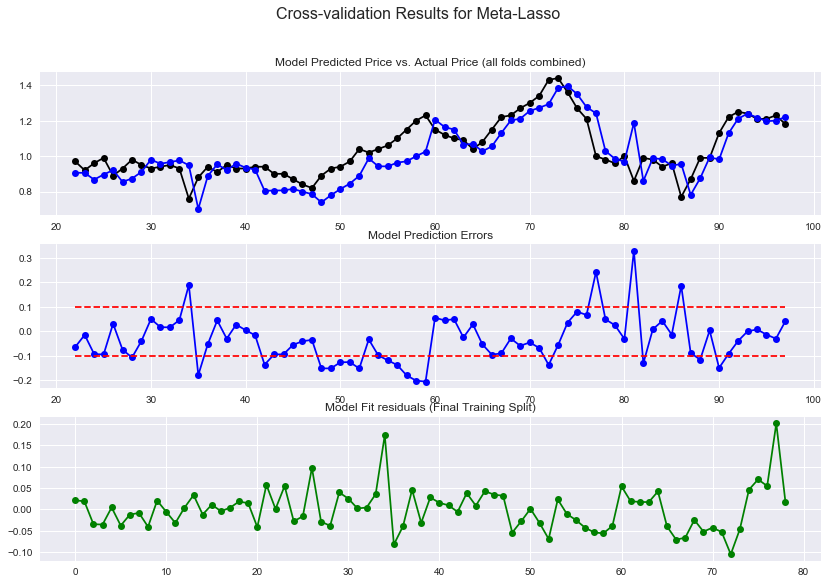

In [123]:
aggregator_model = Lasso(alpha =0.0005, random_state=1)
aggregator_name = "Meta-Lasso"
pipeln = make_pipeline(StandardScaler(), aggregator_model)
meta_handler = TSCrossValidationHandler(pipeln, aggregator_name, n_splits=4)
meta_handler.do_cross_val(X_meta_train, Y_meta_train)
meta_handler.report_metrics()
fig_rf = meta_handler.plot_fits()

Cross-validation results for Random Forrest:
   RMSE:   0.116 ± 0.096
   MAPE: (-1.122 +/- 4.928)%
   N Splits: 3



ValueError: setting an array element with a sequence.

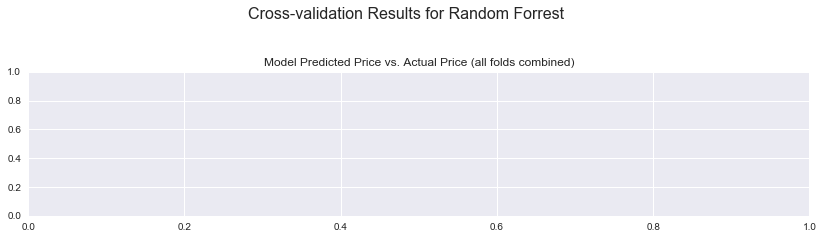

In [131]:
## Now train the L1 models and the aggregator on the entire training set, evaluate and compare
X_tr = X_orig[:i_test_start]
X_tst = X_orig[i_test_start:]
for h in handlers:
    h.model.fit(X_tr, Y_meta_train)
    h.train_resid_Y.append([y-y_true for y_true,y in zip( Y_meta_train, h.model.predict(X_tr))])
    h.train_true_Y.append(Y_meta_train) 
    h.train_X.append(list(range(i_oof_start)))  
    h.train_pred_Y.append(list(h.model.predict(X_tr)))
    h.test_resid_Y.append([y-y_true for y,y_true in zip(h.model.predict(X_tst), Y_meta_test)])
    h.test_true_Y.append(Y_meta_test)
    i_test = list(np.arange(22,99+22))
    h.test_X.append(i_test)
    h.test_pred_Y.append(list(h.model.predict(X_tst)))                                     
    h.mses.append(mean_squared_error(Y_meta_test, h.model.predict(X_tst)))  
    h.mapes.append( 100*np.mean( [ (y-Y)/Y for Y, y in zip(Y_meta_test, h.model.predict(X_tst))  ] ) )
    h.report_metrics()
    h.plot_fits()

In [124]:
len(X_meta_train)

98

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (clf_rfn, clf_xgb, lasso, KRR2),
                                                 meta_model = meta_lasso)

In [ ]:
stacked_rmse = rmsle_cv( meta_lasso, X_L1, Y_L1)
print_result("Stacked", stacked_rmse)
stacked_mape = rmsle_cv( meta_lasso, X_L1, Y_L1, scoring='neg_mean_absolute_error')
print_result( "Stacked", stacked_mape, "MAPE" )
cv_result_table.add_result( "Stacked", {'MSE':ave_std(stacked_rmse), 'MAPE':ave_std(stacked_mape)} )

In [ ]:

y_pred_stacked = meta_lasso.predict(X_oof)
y_resid_stacked = [ yp - y for yp, y in zip(y_pred_stacked, Y_oof)] 

In [ ]:
scaore = rmsle_cv( stacked_averaged_models, X_L1, Y_L1 )

In [ ]:

print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
model_selection = [ (lasso, lasso_rmse_rf), 
                    (clf_xgb, rmse_xgb),
                    (clf_rfn, rmse_rf) ]

In [ ]:
total_rmse = np.sum([ np.mean(a[1]) for a in model_selection ])

In [ ]:
total_rmse

In [ ]:
weights = [ total_rmse/m for m in [ np.mean(a[1]) for a in model_selection  ] ]

In [ ]:
weights

In [ ]:
# Now train the models on all of the training data

In [ ]:
clf_rfn.fit?

In [ ]:
y_df = pd.DataFrame( data=merged_data.iloc[:i_oof_start]['AveragePrice'] )

In [ ]:
# y_df = pd.DataFrame( data=merged_data.iloc[:i_oof_start]['AveragePrice'], columns='AveragePrice')

In [ ]:
tr_resid_df = pd.DataFrame.from_dict( { m : r for m, r in zip(m_names, y_resid) })
#resid_df["X"] = list(X_L1)

In [ ]:
tr_fit_df = pd.DataFrame.from_dict( { m : f for m, f in zip(m_names, y_fits) } )
#fit_df["X"] = list(X_L1)

In [ ]:
f_ax = tr_fit_df.plot(figsize=(14,7), marker='o')
f_ax = plt.plot(y_df.index, y_df['AveragePrice'], marker='o', color='black')
r_ax = tr_resid_df.plot(figsize=(14,7), marker='o')



In [ ]:
y_pred_oof = []
y_pred_oof_resids = []
for p in pipelines:
    m_name = list(p)[0]
    m = p[m_name]
    y_pred_oof.append( m.predict(X_oof) )
    y_pred_oof_resids.append( [ yf - y for yf, y in zip(y_fits[-1], Y_oof) ] )
    m_names.append(m_name)

In [ ]:
y_oof_df = pd.DataFrame( data=merged_data.iloc[i_oof_start:]['AveragePrice'] )
y_oof_df = y_oof_df.reset_index(drop=True)

In [ ]:
oof_resid_df = pd.DataFrame.from_dict( { m : r for m, r in zip(m_names, y_pred_oof_resids) })
#resid_df["X"] = list(X_L1)

oof_fit_df = pd.DataFrame.from_dict( { m : f for m, f in zip(m_names, y_pred_oof) } )
#fit_df["X"] = list(X_L1)

foof_ax = oof_fit_df.plot(figsize=(14,7), marker='o')
foof_ax = plt.plot(y_oof_df.index, y_oof_df['AveragePrice'], marker='o', color='black')
roof_ax = oof_resid_df.plot(figsize=(14,7), marker='o')



In [ ]:
mse_table = { m : mean_squared_error(Y_oof, f) for m, f in zip(m_names, y_pred_oof) }

In [ ]:
mse_table

In [ ]:
mape_table = { m : mean_absolute_error(Y_oof, f) for m, f in zip(m_names, y_pred_oof) }

In [ ]:
mape_table

In [ ]:
resid_df.plot(X='X')

In [ ]:
colormap = plt.cm.binary
plt.figure(figsize=(9,8))
plt.title('Pearson Correlation of Model Fit Residuals', y=1.05, size=15)
ax = sns.heatmap(resid_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Based on the plot above, it looks like XGBoost is the model having the least correlation of its residuals with the other models. Meanwhile, ENet and Lasso Regressors have highly correlated residuals. The random forrest and Kernel Ridge regressors shows moderate to moderatel-high correlations with all other model's residuals. 

Based on these residual correlations and the predictor performance, we choose to eliminate ENet and KRR(3) from our population of Base Learners. 

## Stacked Model with Meta Learner

Note: Non-linear algorithms find useful interactions between the original features and the meta-model features.

In [ ]:
meta_lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (clf_rfn, clf_xgb, lasso, KRR2),
                                                 meta_model = meta_lasso)

In [ ]:
stacked_rmse = rmsle_cv( meta_lasso, X_L1, Y_L1)
print_result("Stacked", stacked_rmse)
stacked_mape = rmsle_cv( meta_lasso, X_L1, Y_L1, scoring='neg_mean_absolute_error')
print_result( "Stacked", stacked_mape, "MAPE" )
cv_result_table.add_result( "Stacked", {'MSE':ave_std(stacked_rmse), 'MAPE':ave_std(stacked_mape)} )

In [ ]:

y_pred_stacked = meta_lasso.predict(X_oof)
y_resid_stacked = [ yp - y for yp, y in zip(y_pred_stacked, Y_oof)] 

In [ ]:
scaore = rmsle_cv( stacked_averaged_models, X_L1, Y_L1 )

In [ ]:

print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
model_selection = [ (lasso, lasso_rmse_rf), 
                    (clf_xgb, rmse_xgb),
                    (clf_rfn, rmse_rf) ]

In [ ]:
total_rmse = np.sum([ np.mean(a[1]) for a in model_selection ])

In [ ]:
total_rmse

In [ ]:
weights = [ total_rmse/m for m in [ np.mean(a[1]) for a in model_selection  ] ]

In [ ]:
weights

In [ ]:
# Now train the models on all of the training data

In [ ]:
clf_rfn.fit?

## Ensemble Prediction

In [ ]:
y_train
y_pred = []
for m in model_selection: